# Data Statistics

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

# Load physiological data (example for one subject)
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    df = pd.read_csv(file_path, sep="\t", names=columns)
    return df

# Segment into 5-second windows
def segment_data(df, window_size=5):
    start_time = df["time"].min()
    df["window"] = ((df["time"] - start_time) // window_size).astype(int)
    return df.groupby("window").mean().reset_index()

# RuLSIF Algorithm for Change-Point Detection
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

# Identify significant changes and label opportune moments
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold
    
    # Clustering the remaining scores
    valid_scores = change_scores[~outliers]
    kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
    centroids = kmeans.cluster_centers_.flatten()
    high_cluster = np.argmax(centroids)
    high_values = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
    
    # Mark opportune moments
    opportune_moments = np.where(outliers | high_values)[0]
    return opportune_moments

# Main execution
file_path = "sub10_DAQ.txt"  # Example file pathho
df = load_data(file_path)
segmented_data = segment_data(df)
change_scores = compute_rulsif_change_scores(segmented_data.iloc[:, 1:].values)
opportune_moments = label_opportune_moments(change_scores)

print("Opportune moments detected at windows:", opportune_moments)

Opportune moments detected at windows: [  1   2   3   4   5   6   7  87  89  90  91  92  93  94  95  96  97  98
  99 135 263 293 308 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 439
 440 441 442 443 444 445]


# User Profile Creation

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# Load physiological data (example for one subject)
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    df = pd.read_csv(file_path, sep="\t", names=columns)
    return df

# Segment into 5-second windows
def segment_data(df, window_size=5):
    start_time = df["time"].min()
    df["window"] = ((df["time"] - start_time) // window_size).astype(int)
    return df.groupby("window").mean().reset_index()

# RuLSIF Algorithm for Change-Point Detection
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

# Identify significant changes and label opportune moments
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold  # Boolean mask (shape = len(change_scores))

    # Ensure valid_scores is extracted correctly
    valid_scores = change_scores[~outliers]  # Exclude outliers

    if len(valid_scores) > 1:  # Prevent issues with too few values
        kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.flatten()
        high_cluster = np.argmax(centroids)
        
        # Assign labels back to original shape
        high_values = np.zeros_like(change_scores, dtype=bool)
        high_values[~outliers] = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
    else:
        high_values = np.zeros_like(change_scores, dtype=bool)

    opportune_moments = np.where(outliers | high_values)[0]
    return opportune_moments




# Compute dataset statistics
def compute_statistics(segmented_data, opportune_moments, window_size=5):
    total_segments = len(segmented_data)
    total_opportune = len(opportune_moments)
    total_inopportune = total_segments - total_opportune
    avg_segments_per_user = np.mean(total_segments)
    sd_segments_per_user = np.std(total_segments)
    duration_per_segment = window_size
    total_duration = segmented_data["window"].max() * window_size
    
    stats = {
        "Total segments": total_segments,
        "Total opportune segments": total_opportune,
        "Total inopportune segments": total_inopportune,
        "Average (SD) segments per user": f"{avg_segments_per_user:.2f} ({sd_segments_per_user:.2f})",
        "Duration per segment (seconds)": duration_per_segment,
        "Total dataset duration (seconds)": total_duration
    }
    return stats

# Visualization
def plot_segment_distribution_pie(total_opportune, total_inopportune):
    labels = ["Opportune Segments", "Inopportune Segments"]
    sizes = [total_opportune, total_inopportune]
    colors = ["#ff9999", "#66b3ff"]
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title("Segment Distribution")
    plt.show()
    
    
# Function to compute change point scores between consecutive segments
def compute_change_point_scores(change_scores):
    """
    Compute the absolute difference between consecutive change scores.
    """
    return np.abs(np.diff(change_scores))

# Function to compute the physiological response profile
def create_physiological_response_profile(change_scores, opportune_moments):
    """
    Computes the user profile <𝜇𝑜𝑝𝑝, 𝜎𝑜𝑝𝑝, 𝜇𝑖𝑛𝑜𝑝𝑝, 𝜎𝑖𝑛𝑜𝑝𝑝>.
    """
    change_point_scores = compute_change_point_scores(change_scores)

    # Ensure opportune_moments indices are valid
    opportune_moments = opportune_moments[opportune_moments < len(change_point_scores)]
    
    all_indices = np.arange(len(change_point_scores))
    inopportune_moments = np.setdiff1d(all_indices, opportune_moments)

    opp_scores = change_point_scores[opportune_moments] if len(opportune_moments) > 0 else np.array([0])
    inopp_scores = change_point_scores[inopportune_moments] if len(inopportune_moments) > 0 else np.array([0])

    mu_opp, sigma_opp = np.mean(opp_scores), np.std(opp_scores)
    mu_inopp, sigma_inopp = np.mean(inopp_scores), np.std(inopp_scores)

    return mu_opp, sigma_opp, mu_inopp, sigma_inopp


for i in range(1,31):
    
# Main execution
    file_path = "../case_dataset/data/raw/physiological/sub"+str(i)+"_DAQ.txt"  # Example file pathho
    df = load_data(file_path)
#     print(len(df))
    segmented_data = segment_data(df)
    change_scores = compute_rulsif_change_scores(segmented_data.iloc[:, 1:].values)
    opportune_moments = label_opportune_moments(change_scores)

#     print("Opportune moments detected at windows:", opportune_moments)


# Compute and print statistics
    stats = compute_statistics(segmented_data, opportune_moments)
#     for key, value in stats.items():
#         print(f"{key}: {value}")

# Plot segment distribution pie chart
#     plot_segment_distribution_pie(stats["Total opportune segments"], stats["Total inopportune segments"])


    total_segments = len(change_scores) - 1  # Total segments available
    mu_opp, sigma_opp, mu_inopp, sigma_inopp = create_physiological_response_profile(change_scores, opportune_moments)

# Print the user profile
    print(f"Physiological Response Profile: (𝜇𝑜𝑝𝑝: {mu_opp:.4f}, 𝜎𝑜𝑝𝑝: {sigma_opp:.4f}, 𝜇𝑖𝑛𝑜𝑝𝑝: {mu_inopp:.4f}, 𝜎𝑖𝑛𝑜𝑝𝑝: {sigma_inopp:.4f})")




Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0005, 𝜎𝑜𝑝𝑝: 0.0014, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0009, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0067)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0035, 𝜎𝑜𝑝𝑝: 0.0034, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0013, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0053)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0021, 𝜎𝑜𝑝𝑝: 0.0033, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0012, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0052)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0040, 𝜎𝑜𝑝𝑝: 0.0046, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0016, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0055)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0061, 𝜎𝑜𝑝𝑝: 0.0067, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0030, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0068)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0032, 𝜎𝑜𝑝𝑝: 0.0029, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0011, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0047)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0231, 𝜎𝑜𝑝𝑝: 0.0279, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0022, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0086)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0015, 𝜎𝑜𝑝𝑝: 0.0015, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0011, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0048)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0016, 𝜎𝑜𝑝𝑝: 0.0015, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0008, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0048)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0025, 𝜎𝑜𝑝𝑝: 0.0031, 𝜇𝑖𝑛𝑜𝑝𝑝: 0.0015, 𝜎𝑖𝑛𝑜𝑝𝑝: 0.0052)
Physiological Response Profile: (𝜇𝑜𝑝𝑝: 0.0006, 𝜎𝑜𝑝𝑝: 0.0005, 𝜇𝑖𝑛𝑜𝑝𝑝: 0

# Identifying Similar User

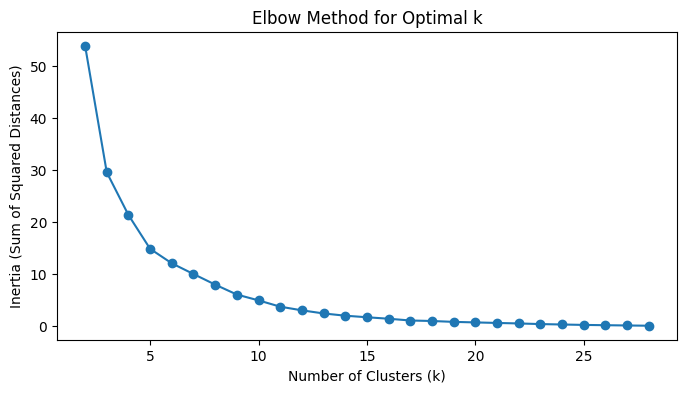

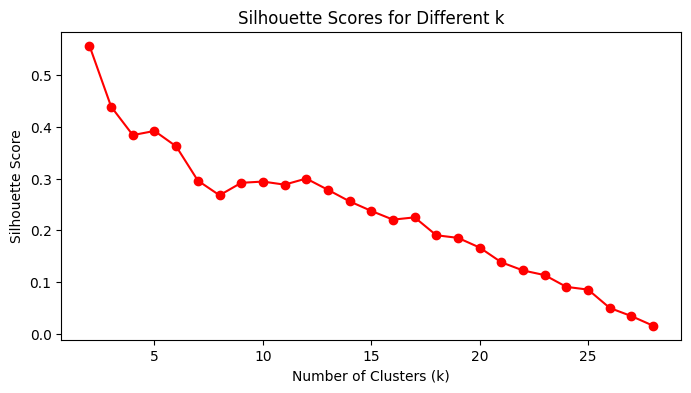

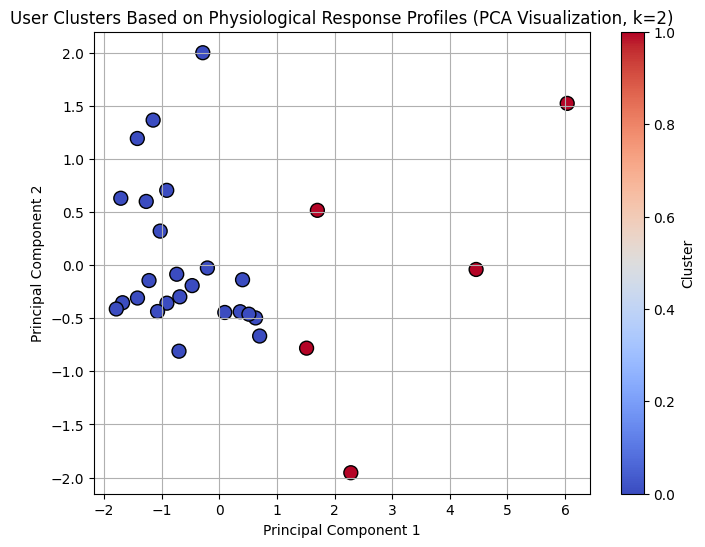

      User  Cluster
0    User1        0
1    User2        0
2    User3        0
3    User4        1
4    User5        1
5    User6        0
6    User8        0
7    User9        0
8   User10        0
9   User11        0
10  User12        0
11  User13        0
12  User14        0
13  User15        0
14  User16        0
15  User17        0
16  User18        1
17  User19        0
18  User20        0
19  User21        0
20  User22        0
21  User23        0
22  User24        0
23  User25        0
24  User26        1
25  User27        0
26  User28        0
27  User29        1
28  User30        0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# User profiles from provided data
df_profiles = pd.DataFrame([
    {"User": "User1", "mu_opp": 0.0005, "sigma_opp": 0.0014, "mu_inopp": 0.0009, "sigma_inopp": 0.0067},
    {"User": "User2", "mu_opp": 0.0035, "sigma_opp": 0.0034, "mu_inopp": 0.0013, "sigma_inopp": 0.0053},
    {"User": "User3", "mu_opp": 0.0021, "sigma_opp": 0.0033, "mu_inopp": 0.0012, "sigma_inopp": 0.0052},
    {"User": "User4", "mu_opp": 0.0040, "sigma_opp": 0.0046, "mu_inopp": 0.0016, "sigma_inopp": 0.0055},
    {"User": "User5", "mu_opp": 0.0061, "sigma_opp": 0.0067, "mu_inopp": 0.0030, "sigma_inopp": 0.0068},
    {"User": "User6", "mu_opp": 0.0020, "sigma_opp": 0.0024, "mu_inopp": 0.0010, "sigma_inopp": 0.0054},
    {"User": "User8", "mu_opp": 0.0015, "sigma_opp": 0.0015, "mu_inopp": 0.0011, "sigma_inopp": 0.0048},
    {"User": "User9", "mu_opp": 0.0016, "sigma_opp": 0.0015, "mu_inopp": 0.0008, "sigma_inopp": 0.0048},
    {"User": "User10", "mu_opp": 0.0025, "sigma_opp": 0.0031, "mu_inopp": 0.0015, "sigma_inopp": 0.0052},
    {"User": "User11", "mu_opp": 0.0004, "sigma_opp": 0.0006, "mu_inopp": 0.0006, "sigma_inopp": 0.0060},
    {"User": "User12", "mu_opp": 0.0009, "sigma_opp": 0.0008, "mu_inopp": 0.0007, "sigma_inopp": 0.0046},
    {"User": "User13", "mu_opp": 0.0019, "sigma_opp": 0.0014, "mu_inopp": 0.0012, "sigma_inopp": 0.0049},
    {"User": "User14", "mu_opp": 0.0031, "sigma_opp": 0.0029, "mu_inopp": 0.0017, "sigma_inopp": 0.0052},
    {"User": "User15", "mu_opp": 0.0029, "sigma_opp": 0.0032, "mu_inopp": 0.0014, "sigma_inopp": 0.0053},
    {"User": "User16", "mu_opp": 0.0007, "sigma_opp": 0.0011, "mu_inopp": 0.0005, "sigma_inopp": 0.0046},
    {"User": "User17", "mu_opp": 0.0011, "sigma_opp": 0.0013, "mu_inopp": 0.0006, "sigma_inopp": 0.0048},
    {"User": "User18", "mu_opp": 0.0052, "sigma_opp": 0.0075, "mu_inopp": 0.0010, "sigma_inopp": 0.0054},
    {"User": "User19", "mu_opp": 0.0022, "sigma_opp": 0.0021, "mu_inopp": 0.0009, "sigma_inopp": 0.0047},
    {"User": "User20", "mu_opp": 0.0024, "sigma_opp": 0.0032, "mu_inopp": 0.0013, "sigma_inopp": 0.0055},
    {"User": "User21", "mu_opp": 0.0002, "sigma_opp": 0.0005, "mu_inopp": 0.0005, "sigma_inopp": 0.0058},
    {"User": "User22", "mu_opp": 0.0003, "sigma_opp": 0.0004, "mu_inopp": 0.0005, "sigma_inopp": 0.0053},
    {"User": "User23", "mu_opp": 0.0008, "sigma_opp": 0.0018, "mu_inopp": 0.0006, "sigma_inopp": 0.0054},
    {"User": "User24", "mu_opp": 0.0007, "sigma_opp": 0.0017, "mu_inopp": 0.0006, "sigma_inopp": 0.0057},
    {"User": "User25", "mu_opp": 0.0007, "sigma_opp": 0.0023, "mu_inopp": 0.0004, "sigma_inopp": 0.0051},
    {"User": "User26", "mu_opp": 0.0064, "sigma_opp": 0.0065, "mu_inopp": 0.0043, "sigma_inopp": 0.0080},
    {"User": "User27", "mu_opp": 0.0016, "sigma_opp": 0.0016, "mu_inopp": 0.0010, "sigma_inopp": 0.0051},
    {"User": "User28", "mu_opp": 0.0006, "sigma_opp": 0.0012, "mu_inopp": 0.0005, "sigma_inopp": 0.0055},
    {"User": "User29", "mu_opp": 0.0032, "sigma_opp": 0.0036, "mu_inopp": 0.0021, "sigma_inopp": 0.0062},
    {"User": "User30", "mu_opp": 0.0017, "sigma_opp": 0.0027, "mu_inopp": 0.0007, "sigma_inopp": 0.0053},
])


# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_profiles[["mu_opp", "sigma_opp", "mu_inopp", "sigma_inopp"]])

# Determine the optimal number of clusters using the Elbow method
inertia = []
silhouette_scores = []
K_range = range(2, 29)  # Testing k from 2 to 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot the elbow method
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="-", color="r")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.show()

# Use the best k from silhouette score (manually choose based on plots)
best_k = 2  # Change this based on the above graphs
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_profiles["Cluster"] = kmeans.fit_predict(X_scaled)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_profiles["PCA1"] = X_pca[:, 0]
df_profiles["PCA2"] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_profiles["PCA1"], df_profiles["PCA2"], c=df_profiles["Cluster"], cmap="coolwarm", edgecolors="k", s=100)
# for i, txt in enumerate(df_profiles["User"]):
#     plt.annotate(txt, (df_profiles["PCA1"][i] + 0.0001, df_profiles["PCA2"][i] + 0.0001))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"User Clusters Based on Physiological Response Profiles (PCA Visualization, k={best_k})")
plt.colorbar(label="Cluster")
plt.grid(True)

plt.savefig("user_clusters.png", dpi=300, bbox_inches='tight')


plt.show()

# Print the clustered user profiles
print(df_profiles[["User", "Cluster"]])


# model cosidersing all features as input

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout, Bidirectional, Multiply, Flatten, Lambda,RepeatVector, Permute 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.stats import zscore
from sklearn.metrics.pairwise import rbf_kernel
from scipy.signal import resample, butter, filtfilt, welch
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.cluster import KMeans

# Constants for sampling rates
PHYSIO_SAMPLING_RATE = 1000  # Hz
VALENCE_SAMPLING_RATE = 20    # Hz
DOWNSAMPLE_FACTOR = PHYSIO_SAMPLING_RATE // VALENCE_SAMPLING_RATE  # 50

# Load physiological data with proper downsampling
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    
    # Read all data first
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Downsample physiological data to match valence-arousal sampling rate
    downsampled_df = df.iloc[::DOWNSAMPLE_FACTOR, :].copy()
    
    # Reset time to new sampling rate
    downsampled_df["time"] = np.arange(len(downsampled_df)) / VALENCE_SAMPLING_RATE
    
    return downsampled_df

# Load valence-arousal data (already at 20Hz)
def load_valence_arousal_data(file_path):
    columns = ["jstime", "valence", "arousal"]
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Convert time to seconds and align with physiological data
    df["jstime"] = df["jstime"] / 1000  # convert ms to seconds
    
    return df

# Segment into 5-second windows with proper alignment
def segment_data(physio_df, valence_df, window_size=5):
    # Calculate number of samples per window
    samples_per_window = window_size * VALENCE_SAMPLING_RATE
    
    # Segment physiological data
    physio_segments = []
    for i in range(0, len(physio_df), samples_per_window):
        segment = physio_df.iloc[i:i+samples_per_window]
        if len(segment) == samples_per_window:  # only complete segments
            # Calculate time-domain features
            features = {
                "time": segment["time"].mean(),
                "ECG_mean": segment["ECG"].mean(),
                "ECG_std": segment["ECG"].std(),
                "ECG_hr": 60 / (segment["ECG"].diff().abs().mean() + 1e-6),  # rough HR estimate
                "BVP_mean": segment["BVP"].mean(),
                "BVP_std": segment["BVP"].std(),
                "GSR_mean": segment["GSR"].mean(),
                "GSR_std": segment["GSR"].std(),
                "GSR_slope": np.polyfit(np.arange(len(segment)), segment["GSR"], 1)[0],
                "Resp_mean": segment["Resp"].mean(),
                "Resp_std": segment["Resp"].std(),
                "Resp_rate": len(np.where(np.diff(np.sign(segment["Resp"] - segment["Resp"].mean())))[0]) / 2,  # zero crossings
                "Skin_temp_mean": segment["Skin_Temp"].mean(),
                "Skin_temp_std": segment["Skin_Temp"].std(),
                "EMG_mean": segment[["EMG_z", "EMG_c", "EMG_t"]].mean().mean(),
                "EMG_std": segment[["EMG_z", "EMG_c", "EMG_t"]].std().mean()
            }
            physio_segments.append(features)
    
    # Segment valence-arousal data
    valence_segments = []
    for i in range(0, len(valence_df), samples_per_window):
        segment = valence_df.iloc[i:i+samples_per_window]
        if len(segment) == samples_per_window:  # only complete segments
            features = {
                "time": segment["jstime"].mean(),
                "valence_mean": segment["valence"].mean(),
                "valence_std": segment["valence"].std(),
                "arousal_mean": segment["arousal"].mean(),
                "arousal_std": segment["arousal"].std(),
                "valence_slope": np.polyfit(np.arange(len(segment)), segment["valence"], 1)[0],
                "arousal_slope": np.polyfit(np.arange(len(segment)), segment["arousal"], 1)[0]
            }
            valence_segments.append(features)
    
    # Merge segments by time (nearest neighbor)
    physio_df = pd.DataFrame(physio_segments)
    valence_df = pd.DataFrame(valence_segments)
    
    # Merge on the closest time
    merged_df = pd.merge_asof(physio_df.sort_values('time'), 
                            valence_df.sort_values('time'), 
                            on='time', 
                            direction='nearest')
    
    return merged_df

# Enhanced feature engineering
def extract_physiological_features(segment):
    """Extract time and frequency domain features from a physiological segment"""
    features = {}
    
    # Time-domain features
    for signal in ['ECG', 'BVP', 'GSR', 'Resp', 'Skin_Temp']:
        sig_data = segment[signal].values
        features.update({
            f"{signal}_mean": np.mean(sig_data),
            f"{signal}_std": np.std(sig_data),
            f"{signal}_max": np.max(sig_data),
            f"{signal}_min": np.min(sig_data),
            f"{signal}_range": np.ptp(sig_data),
            f"{signal}_slope": np.polyfit(np.arange(len(sig_data)), sig_data, 1)[0],
            f"{signal}_diff_mean": np.mean(np.diff(sig_data)),
            f"{signal}_diff_std": np.std(np.diff(sig_data))
        })
    
    # Frequency-domain features (using Welch's method)
    for signal in ['ECG', 'BVP', 'GSR']:
        sig_data = segment[signal].values
        f, Pxx = welch(sig_data, fs=VALENCE_SAMPLING_RATE, nperseg=min(len(sig_data), 256))
        features.update({
            f"{signal}_psd_mean": np.mean(Pxx),
            f"{signal}_psd_std": np.std(Pxx),
            f"{signal}_psd_max": np.max(Pxx),
            f"{signal}_psd_max_freq": f[np.argmax(Pxx)],
            f"{signal}_psd_ratio": np.sum(Pxx[f > 0.1]) / (np.sum(Pxx) + 1e-6)  # ratio of high freq components
        })
    
    # Combined features
    features['HRV'] = np.std(np.diff(np.where(np.diff(segment['ECG']) > 0.5 * np.std(segment['ECG']))[0]))
    features['GSR_peaks'] = len(find_peaks(segment['GSR'], height=np.mean(segment['GSR']))[0])
    
    return features

# RuLSIF Algorithm for Change-Point Detection (unchanged)
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

# Identify significant changes and label opportune moments (unchanged)
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold
    
    # Clustering the remaining scores
    valid_indices = np.where(~outliers)[0]  # Indices of non-outliers
    valid_scores = change_scores[valid_indices]
    
    if len(valid_scores) > 1:  # Ensure there are enough samples for clustering
        kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.flatten()
        high_cluster = np.argmax(centroids)
        high_values = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
        
        # Map high_values back to the original indices
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
        high_values_mapped[valid_indices] = high_values
    else:
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
    
    # Mark opportune moments
    opportune_moments = np.where(outliers | high_values_mapped)[0]
    return opportune_moments

# Enhanced input preparation with more emotion-relevant features
def prepare_input(segmented_data, change_scores):
    # Select features that are most relevant for emotion detection
    features = [
        # Physiological features
        'ECG_mean', 'ECG_std', 'ECG_hr', 
        'BVP_mean', 'BVP_std',
        'GSR_mean', 'GSR_std', 'GSR_slope',
        'Resp_mean', 'Resp_std', 'Resp_rate',
        'Skin_temp_mean', 'Skin_temp_std',
        'EMG_mean', 'EMG_std',
        
        # Valence-arousal features
        'valence_mean', 'valence_std', 'valence_slope',
        'arousal_mean', 'arousal_std', 'arousal_slope'
    ]
    
    # Add change point scores
    segmented_data['change_score'] = np.concatenate([[0], change_scores])[:len(segmented_data)]
    
    # Prepare input sequence
    input_sequence = segmented_data[features + ['change_score']].values
    
    # Robust scaling (less sensitive to outliers)
    scaler = RobustScaler()
    input_sequence = scaler.fit_transform(input_sequence)
    
    return input_sequence

# [Rest of the code remains the same...]


# Parameterized Elliott Activation Function (PEF)
def elliott(x, p):
    return (p * x) / (1 + K.abs(x))

# Derivative of PEF
def elliott_derivative(x, p):
    return p / ((K.abs(x) + 1) ** 2)

# Swish Activation Function
def swish(x):
    return x * K.sigmoid(x)

# Custom PEF Activation Layer
class PEFLayer(Activation):
    def __init__(self, activation, **kwargs):
        super(PEFLayer, self).__init__(activation, **kwargs)
        self.p = K.variable(1.0)  # Initialize parameter p

    def call(self, inputs):
        return elliott(inputs, self.p)

# Build p-LSTM Model
def build_p_lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # p-LSTM Layer with PEF activation
    lstm_out = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))(inputs)
    lstm_out = Dropout(0.5)(lstm_out)  # Dropout for regularization
    lstm_out = PEFLayer(elliott)(lstm_out)
    
    # Fully Connected Layers with PEF activation
    dense1 = Dense(16, kernel_regularizer=l2(0.01))(lstm_out)
    dense1 = Dropout(0.5)(dense1)  # Dropout for regularization
    dense1 = PEFLayer(elliott)(dense1)
    
    # Swish Activation Layer
    swish_out = Activation(swish)(dense1)
    
    # Sigmoid Output Layer for Binary Classification
    outputs = Dense(1, activation="sigmoid")(swish_out)
    
    # Define Model
    model = Model(inputs, outputs)
    return model

# [Keep all your existing imports and functions until main()]

def main():
    # User profiles with pre-defined clusters
    df_profiles = pd.DataFrame({
        "User": ["User1", "User2", "User3", "User4", "User5", "User6", "User8", "User9", "User10",
                "User11", "User12", "User13", "User14", "User15", "User16", "User17", "User18",
                "User19", "User20", "User21", "User22", "User23", "User24", "User25", "User26",
                "User27", "User28", "User29", "User30"],
        "Cluster": [0, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 1, 0]
    })

    # Preprocess data for all users
    user_inputs = {}
    user_labels = {}
    for i in range(1, 31):
        user_id = f"User{i}"
        # Skip User7 which doesn't exist in your list
        if i == 7:
            continue
            
        try:
            physio_file = f"../case_dataset/data/raw/physiological/sub{i}_DAQ.txt"
            valence_arousal_file = f"../case_dataset/data/raw/annotations/sub{i}_joystick.txt"
            
            # Load data with proper sampling rate handling
            df_physio = load_data(physio_file)
            df_valence_arousal = load_valence_arousal_data(valence_arousal_file)
            
            # Segment data with proper alignment
            segmented_data = segment_data(df_physio, df_valence_arousal)
            
            # Compute change scores using all physiological features
            physio_features = segmented_data[['ECG_mean', 'BVP_mean', 'GSR_mean', 
                                            'Resp_mean', 'Skin_temp_mean', 'EMG_mean']].values
            change_scores = compute_rulsif_change_scores(physio_features)
            
            # Label opportune moments
            opportune_moments = label_opportune_moments(change_scores)
            labels = np.zeros(len(segmented_data))
            labels[opportune_moments] = 1
            
            # Prepare enhanced input sequence
            input_sequence = prepare_input(segmented_data, change_scores)
            
            # Only keep samples where we have all data
            valid_indices = ~np.isnan(input_sequence).any(axis=1)
            input_sequence = input_sequence[valid_indices]
            labels = labels[valid_indices]
            
            user_inputs[user_id] = input_sequence
            user_labels[user_id] = labels
            
        except FileNotFoundError:
            print(f"Data for {user_id} not found. Skipping...")
            continue
    
    # Train and evaluate p-LSTM model for each user
    for user, input_sequence in user_inputs.items():
        # Get the cluster for current user
        cluster = df_profiles[df_profiles["User"] == user]["Cluster"].values[0]
        
        # Find similar users in same cluster (excluding current user)
        similar_users = [u for u in df_profiles[df_profiles["Cluster"] == cluster]["User"] if u != user]
        
        # Prepare training data only from available similar users
        train_data = []
        train_labels = []
        for u in similar_users:
            if u in user_inputs:  # Check if user data exists
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])
        
        if not train_data:  # Skip if no training data available
            print(f"No training data available for {user}. Skipping...")
            continue
            
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        
        # Prepare test data
        test_data = input_sequence
        test_labels = user_labels[user]
        
        print(f"\nTraining {user} on: {[u for u in similar_users if u in user_inputs]}")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Class distribution - Train: {np.bincount(train_labels.astype(int))}, Test: {np.bincount(test_labels.astype(int))}")
        
        # Reshape for LSTM [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))
        
        # Build and train model
        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss=BinaryCrossentropy(), 
                     metrics=["accuracy"])
        
        # Class weights for imbalance
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )
        
        # Evaluation
        y_pred = model.predict(test_data)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        print(classification_report(test_labels, y_pred_classes))
        print(f"AUC-ROC: {roc_auc_score(test_labels, y_pred):.3f}")

if __name__ == "__main__":
    main()


Training User1 on: ['User2', 'User3', 'User6', 'User8', 'User9', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15', 'User16', 'User17', 'User19', 'User20', 'User21', 'User22', 'User23', 'User24', 'User25', 'User27', 'User28', 'User30']
Train samples: 11270, Test samples: 490
Class distribution - Train: [9680 1590], Test: [341 149]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

         0.0       0.74      0.98      0.84       341
         1.0       0.84      0.21      0.34       149

    accuracy                           0.75       490
   macro avg       0.79      0.60      0.59       490
weighted avg       0.77      0.75      0.69       490

AUC-ROC: 0.964

Training User2 on: ['User1', 'User3', 'User6', 'User8', 'User9', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15', 'User16', 'User17', 'User19', 'User20', 'User21', 'User22', 'User23', 'User24', 'User25', 'User27', 'User28', 'User30']
Train samples: 11270, Test sam

# model considering only physiological signal as input

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout, Bidirectional, Multiply, Flatten, Lambda,RepeatVector, Permute 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.stats import zscore
from sklearn.metrics.pairwise import rbf_kernel
from scipy.signal import resample, butter, filtfilt, welch
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.cluster import KMeans

# Constants for sampling rates
PHYSIO_SAMPLING_RATE = 1000  # Hz
VALENCE_SAMPLING_RATE = 20    # Hz
DOWNSAMPLE_FACTOR = PHYSIO_SAMPLING_RATE // VALENCE_SAMPLING_RATE  # 50

# Load physiological data with proper downsampling
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    
    # Read all data first
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Downsample physiological data to match valence-arousal sampling rate
    downsampled_df = df.iloc[::DOWNSAMPLE_FACTOR, :].copy()
    
    # Reset time to new sampling rate
    downsampled_df["time"] = np.arange(len(downsampled_df)) / VALENCE_SAMPLING_RATE
    
    return downsampled_df

# Load valence-arousal data (already at 20Hz)
def load_valence_arousal_data(file_path):
    columns = ["jstime", "valence", "arousal"]
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Convert time to seconds and align with physiological data
    df["jstime"] = df["jstime"] / 1000  # convert ms to seconds
    
    return df

# Segment into 5-second windows with proper alignment
def segment_data(physio_df, window_size=5):  # Removed valence_df parameter
    # Calculate number of samples per window
    samples_per_window = window_size * VALENCE_SAMPLING_RATE
    
    # Segment physiological data only
    segments = []
    for i in range(0, len(physio_df), samples_per_window):
        segment = physio_df.iloc[i:i+samples_per_window]
        if len(segment) == samples_per_window:  # only complete segments
            # Calculate time-domain features
            features = {
                "time": segment["time"].mean(),
                "ECG_mean": segment["ECG"].mean(),
                "ECG_std": segment["ECG"].std(),
                "ECG_hr": 60 / (segment["ECG"].diff().abs().mean() + 1e-6),
                "BVP_mean": segment["BVP"].mean(),
                "BVP_std": segment["BVP"].std(),
                "GSR_mean": segment["GSR"].mean(),
                "GSR_std": segment["GSR"].std(),
                "GSR_slope": np.polyfit(np.arange(len(segment)), segment["GSR"], 1)[0],
                "Resp_mean": segment["Resp"].mean(),
                "Resp_std": segment["Resp"].std(),
                "Resp_rate": len(np.where(np.diff(np.sign(segment["Resp"] - segment["Resp"].mean())))[0]) / 2,
                "Skin_temp_mean": segment["Skin_Temp"].mean(),
                "Skin_temp_std": segment["Skin_Temp"].std(),
                "EMG_mean": segment[["EMG_z", "EMG_c", "EMG_t"]].mean().mean(),
                "EMG_std": segment[["EMG_z", "EMG_c", "EMG_t"]].std().mean()
            }
            segments.append(features)
    
    return pd.DataFrame(segments)


# Enhanced feature engineering
def extract_physiological_features(segment):
    """Extract time and frequency domain features from a physiological segment"""
    features = {}
    
    # Time-domain features
    for signal in ['ECG', 'BVP', 'GSR', 'Resp', 'Skin_Temp']:
        sig_data = segment[signal].values
        features.update({
            f"{signal}_mean": np.mean(sig_data),
            f"{signal}_std": np.std(sig_data),
            f"{signal}_max": np.max(sig_data),
            f"{signal}_min": np.min(sig_data),
            f"{signal}_range": np.ptp(sig_data),
            f"{signal}_slope": np.polyfit(np.arange(len(sig_data)), sig_data, 1)[0],
            f"{signal}_diff_mean": np.mean(np.diff(sig_data)),
            f"{signal}_diff_std": np.std(np.diff(sig_data))
        })
    
    # Frequency-domain features (using Welch's method)
    for signal in ['ECG', 'BVP', 'GSR']:
        sig_data = segment[signal].values
        f, Pxx = welch(sig_data, fs=VALENCE_SAMPLING_RATE, nperseg=min(len(sig_data), 256))
        features.update({
            f"{signal}_psd_mean": np.mean(Pxx),
            f"{signal}_psd_std": np.std(Pxx),
            f"{signal}_psd_max": np.max(Pxx),
            f"{signal}_psd_max_freq": f[np.argmax(Pxx)],
            f"{signal}_psd_ratio": np.sum(Pxx[f > 0.1]) / (np.sum(Pxx) + 1e-6)  # ratio of high freq components
        })
    
    # Combined features
    features['HRV'] = np.std(np.diff(np.where(np.diff(segment['ECG']) > 0.5 * np.std(segment['ECG']))[0]))
    features['GSR_peaks'] = len(find_peaks(segment['GSR'], height=np.mean(segment['GSR']))[0])
    
    return features

# RuLSIF Algorithm for Change-Point Detection (unchanged)
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

# Identify significant changes and label opportune moments (unchanged)
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold
    
    # Clustering the remaining scores
    valid_indices = np.where(~outliers)[0]  # Indices of non-outliers
    valid_scores = change_scores[valid_indices]
    
    if len(valid_scores) > 1:  # Ensure there are enough samples for clustering
        kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.flatten()
        high_cluster = np.argmax(centroids)
        high_values = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
        
        # Map high_values back to the original indices
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
        high_values_mapped[valid_indices] = high_values
    else:
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
    
    # Mark opportune moments
    opportune_moments = np.where(outliers | high_values_mapped)[0]
    return opportune_moments

# Enhanced input preparation with more emotion-relevant features
def prepare_input(segmented_data, change_scores):
    # Select only physiological features
    features = [
        'ECG_mean', 'ECG_std', 'ECG_hr', 
        'BVP_mean', 'BVP_std',
        'GSR_mean', 'GSR_std', 'GSR_slope',
        'Resp_mean', 'Resp_std', 'Resp_rate',
        'Skin_temp_mean', 'Skin_temp_std',
        'EMG_mean', 'EMG_std'
    ]
    
    # Add change point scores
    segmented_data['change_score'] = np.concatenate([[0], change_scores])[:len(segmented_data)]
    
    # Prepare input sequence
    input_sequence = segmented_data[features + ['change_score']].values
    
    # Robust scaling
    scaler = RobustScaler()
    input_sequence = scaler.fit_transform(input_sequence)
    
    return input_sequence


# Parameterized Elliott Activation Function (PEF)
def elliott(x, p):
    return (p * x) / (1 + K.abs(x))

# Derivative of PEF
def elliott_derivative(x, p):
    return p / ((K.abs(x) + 1) ** 2)

# Swish Activation Function
def swish(x):
    return x * K.sigmoid(x)

# Custom PEF Activation Layer
class PEFLayer(Activation):
    def __init__(self, activation, **kwargs):
        super(PEFLayer, self).__init__(activation, **kwargs)
        self.p = K.variable(1.0)  # Initialize parameter p

    def call(self, inputs):
        return elliott(inputs, self.p)

# Build p-LSTM Model
def build_p_lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # p-LSTM Layer with PEF activation
    lstm_out = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))(inputs)
    lstm_out = Dropout(0.5)(lstm_out)  # Dropout for regularization
    lstm_out = PEFLayer(elliott)(lstm_out)
    
    # Fully Connected Layers with PEF activation
    dense1 = Dense(16, kernel_regularizer=l2(0.01))(lstm_out)
    dense1 = Dropout(0.5)(dense1)  # Dropout for regularization
    dense1 = PEFLayer(elliott)(dense1)
    
    # Swish Activation Layer
    swish_out = Activation(swish)(dense1)
    
    # Sigmoid Output Layer for Binary Classification
    outputs = Dense(1, activation="sigmoid")(swish_out)
    
    # Define Model
    model = Model(inputs, outputs)
    return model

# [Keep all your existing imports and functions until main()]

def main():
    
    user_reports = []

    # User profiles with pre-defined clusters
    df_profiles = pd.DataFrame({
        "User": ["User1", "User2", "User3", "User4", "User5", "User6", "User8", "User9", "User10",
                "User11", "User12", "User13", "User14", "User15", "User16", "User17", "User18",
                "User19", "User20", "User21", "User22", "User23", "User24", "User25", "User26",
                "User27", "User28", "User29", "User30"],
        "Cluster": [0, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 1, 0]
    })

    # Preprocess data for all users
    user_inputs = {}
    user_labels = {}
    for i in range(1, 31):
        user_id = f"User{i}"
        # Skip User7 which doesn't exist in your list
        if i == 7:
            continue
            
        try:
            physio_file = f"../case_dataset/data/raw/physiological/sub{i}_DAQ.txt"
            
            # Load only physiological data
            df_physio = load_data(physio_file)
            
            # Segment data (now only needs physio data)
            segmented_data = segment_data(df_physio)
            
            # Compute change scores
            physio_features = segmented_data[['ECG_mean', 'BVP_mean', 'GSR_mean', 
                                           'Resp_mean', 'Skin_temp_mean', 'EMG_mean']].values
            change_scores = compute_rulsif_change_scores(physio_features)
            
            # Label opportune moments
            opportune_moments = label_opportune_moments(change_scores)
            labels = np.zeros(len(segmented_data))
            labels[opportune_moments] = 1
            
            # Prepare input sequence (now without valence/arousal)
            input_sequence = prepare_input(segmented_data, change_scores)
            
            # Only keep samples where we have all data
            valid_indices = ~np.isnan(input_sequence).any(axis=1)
            input_sequence = input_sequence[valid_indices]
            labels = labels[valid_indices]
            
            user_inputs[user_id] = input_sequence
            user_labels[user_id] = labels
            
        except FileNotFoundError:
            print(f"Data for {user_id} not found. Skipping...")
            continue
    
    # Train and evaluate p-LSTM model for each user
    for user, input_sequence in user_inputs.items():
        # Get the cluster for current user
        cluster = df_profiles[df_profiles["User"] == user]["Cluster"].values[0]
        
        # Find similar users in same cluster (excluding current user)
        similar_users = [u for u in df_profiles[df_profiles["Cluster"] == cluster]["User"] if u != user]
        
        # Prepare training data only from available similar users
        train_data = []
        train_labels = []
        for u in similar_users:
            if u in user_inputs:  # Check if user data exists
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])
        
        if not train_data:  # Skip if no training data available
            print(f"No training data available for {user}. Skipping...")
            continue
            
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        
        # Prepare test data
        test_data = input_sequence
        test_labels = user_labels[user]
        
        print(f"\nTraining {user} on: {[u for u in similar_users if u in user_inputs]}")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Class distribution - Train: {np.bincount(train_labels.astype(int))}, Test: {np.bincount(test_labels.astype(int))}")
        
        # Reshape for LSTM [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))
        
        # Build and train model
        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss=BinaryCrossentropy(), 
                     metrics=["accuracy"])
        
        # Class weights for imbalance
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )
        
        # Evaluation
        y_pred = model.predict(test_data)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        print(classification_report(test_labels, y_pred_classes))
        print(f"AUC-ROC: {roc_auc_score(test_labels, y_pred):.3f}")
        
        

if __name__ == "__main__":
    main()


Training User1 on: ['User2', 'User3', 'User6', 'User8', 'User9', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15', 'User16', 'User17', 'User19', 'User20', 'User21', 'User22', 'User23', 'User24', 'User25', 'User27', 'User28', 'User30']
Train samples: 11270, Test samples: 490
Class distribution - Train: [9680 1590], Test: [341 149]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.99      0.85       341
         1.0       0.92      0.23      0.37       149

    accuracy                           0.76       490
   macro avg       0.83      0.61      0.61       490
weighted avg       0.80      0.76      0.71       490

AUC-ROC: 0.975

Training User2 on: ['User1', 'User3', 'User6', 'User8', 'User9', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15', 'User16', 'User17', 'User19', 'User20', 'User21', 'User22', 'User23', 'User24', 'User25', 'User27', 'User28', 'User30']
Train samples: 11270, Test sa

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout, Bidirectional, Multiply, Flatten, Lambda,RepeatVector, Permute 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.stats import zscore
from sklearn.metrics.pairwise import rbf_kernel
from scipy.signal import resample, butter, filtfilt, welch
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.cluster import KMeans

# Constants for sampling rates
PHYSIO_SAMPLING_RATE = 1000  # Hz
VALENCE_SAMPLING_RATE = 20    # Hz
DOWNSAMPLE_FACTOR = PHYSIO_SAMPLING_RATE // VALENCE_SAMPLING_RATE  # 50

# Load physiological data with proper downsampling
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    
    # Read all data first
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Downsample physiological data to match valence-arousal sampling rate
    downsampled_df = df.iloc[::DOWNSAMPLE_FACTOR, :].copy()
    
    # Reset time to new sampling rate
    downsampled_df["time"] = np.arange(len(downsampled_df)) / VALENCE_SAMPLING_RATE
    
    return downsampled_df

# Load valence-arousal data (already at 20Hz)
def load_valence_arousal_data(file_path):
    columns = ["jstime", "valence", "arousal"]
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Convert time to seconds and align with physiological data
    df["jstime"] = df["jstime"] / 1000  # convert ms to seconds
    
    return df

# Segment into 5-second windows with proper alignment
def segment_data(physio_df, window_size=5):  # Removed valence_df parameter
    # Calculate number of samples per window
    samples_per_window = window_size * VALENCE_SAMPLING_RATE
    
    # Segment physiological data only
    segments = []
    for i in range(0, len(physio_df), samples_per_window):
        segment = physio_df.iloc[i:i+samples_per_window]
        if len(segment) == samples_per_window:  # only complete segments
            # Calculate time-domain features
            features = {
                "time": segment["time"].mean(),
                "ECG_mean": segment["ECG"].mean(),
                "ECG_std": segment["ECG"].std(),
                "ECG_hr": 60 / (segment["ECG"].diff().abs().mean() + 1e-6),
                "BVP_mean": segment["BVP"].mean(),
                "BVP_std": segment["BVP"].std(),
                "GSR_mean": segment["GSR"].mean(),
                "GSR_std": segment["GSR"].std(),
                "GSR_slope": np.polyfit(np.arange(len(segment)), segment["GSR"], 1)[0],
                "Resp_mean": segment["Resp"].mean(),
                "Resp_std": segment["Resp"].std(),
                "Resp_rate": len(np.where(np.diff(np.sign(segment["Resp"] - segment["Resp"].mean())))[0]) / 2,
                "Skin_temp_mean": segment["Skin_Temp"].mean(),
                "Skin_temp_std": segment["Skin_Temp"].std(),
                "EMG_mean": segment[["EMG_z", "EMG_c", "EMG_t"]].mean().mean(),
                "EMG_std": segment[["EMG_z", "EMG_c", "EMG_t"]].std().mean()
            }
            segments.append(features)
    
    return pd.DataFrame(segments)


# Enhanced feature engineering
def extract_physiological_features(segment):
    """Extract time and frequency domain features from a physiological segment"""
    features = {}
    
    # Time-domain features
    for signal in ['ECG', 'BVP', 'GSR', 'Resp', 'Skin_Temp']:
        sig_data = segment[signal].values
        features.update({
            f"{signal}_mean": np.mean(sig_data),
            f"{signal}_std": np.std(sig_data),
            f"{signal}_max": np.max(sig_data),
            f"{signal}_min": np.min(sig_data),
            f"{signal}_range": np.ptp(sig_data),
            f"{signal}_slope": np.polyfit(np.arange(len(sig_data)), sig_data, 1)[0],
            f"{signal}_diff_mean": np.mean(np.diff(sig_data)),
            f"{signal}_diff_std": np.std(np.diff(sig_data))
        })
    
    # Frequency-domain features (using Welch's method)
    for signal in ['ECG', 'BVP', 'GSR']:
        sig_data = segment[signal].values
        f, Pxx = welch(sig_data, fs=VALENCE_SAMPLING_RATE, nperseg=min(len(sig_data), 256))
        features.update({
            f"{signal}_psd_mean": np.mean(Pxx),
            f"{signal}_psd_std": np.std(Pxx),
            f"{signal}_psd_max": np.max(Pxx),
            f"{signal}_psd_max_freq": f[np.argmax(Pxx)],
            f"{signal}_psd_ratio": np.sum(Pxx[f > 0.1]) / (np.sum(Pxx) + 1e-6)  # ratio of high freq components
        })
    
    # Combined features
    features['HRV'] = np.std(np.diff(np.where(np.diff(segment['ECG']) > 0.5 * np.std(segment['ECG']))[0]))
    features['GSR_peaks'] = len(find_peaks(segment['GSR'], height=np.mean(segment['GSR']))[0])
    
    return features

# RuLSIF Algorithm for Change-Point Detection (unchanged)
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

# Identify significant changes and label opportune moments (unchanged)
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold
    
    # Clustering the remaining scores
    valid_indices = np.where(~outliers)[0]  # Indices of non-outliers
    valid_scores = change_scores[valid_indices]
    
    if len(valid_scores) > 1:  # Ensure there are enough samples for clustering
        kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.flatten()
        high_cluster = np.argmax(centroids)
        high_values = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
        
        # Map high_values back to the original indices
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
        high_values_mapped[valid_indices] = high_values
    else:
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
    
    # Mark opportune moments
    opportune_moments = np.where(outliers | high_values_mapped)[0]
    return opportune_moments

# Enhanced input preparation with more emotion-relevant features
def prepare_input(segmented_data, change_scores):
    # Select only physiological features
    features = [
        'ECG_mean', 'ECG_std', 'ECG_hr', 
        'BVP_mean', 'BVP_std',
        'GSR_mean', 'GSR_std', 'GSR_slope',
        'Resp_mean', 'Resp_std', 'Resp_rate',
        'Skin_temp_mean', 'Skin_temp_std',
        'EMG_mean', 'EMG_std'
    ]
    
    # Add change point scores
    segmented_data['change_score'] = np.concatenate([[0], change_scores])[:len(segmented_data)]
    
    # Prepare input sequence
    input_sequence = segmented_data[features + ['change_score']].values
    
    # Robust scaling
    scaler = RobustScaler()
    input_sequence = scaler.fit_transform(input_sequence)
    
    return input_sequence


# Parameterized Elliott Activation Function (PEF)
def elliott(x, p):
    return (p * x) / (1 + K.abs(x))

# Derivative of PEF
def elliott_derivative(x, p):
    return p / ((K.abs(x) + 1) ** 2)

# Swish Activation Function
def swish(x):
    return x * K.sigmoid(x)

# Custom PEF Activation Layer
class PEFLayer(Activation):
    def __init__(self, activation, **kwargs):
        super(PEFLayer, self).__init__(activation, **kwargs)
        self.p = K.variable(1.0)  # Initialize parameter p

    def call(self, inputs):
        return elliott(inputs, self.p)

# Build p-LSTM Model
def build_p_lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # p-LSTM Layer with PEF activation
    lstm_out = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))(inputs)
    lstm_out = Dropout(0.5)(lstm_out)  # Dropout for regularization
    lstm_out = PEFLayer(elliott)(lstm_out)
    
    # Fully Connected Layers with PEF activation
    dense1 = Dense(16, kernel_regularizer=l2(0.01))(lstm_out)
    dense1 = Dropout(0.5)(dense1)  # Dropout for regularization
    dense1 = PEFLayer(elliott)(dense1)
    
    # Swish Activation Layer
    swish_out = Activation(swish)(dense1)
    
    # Sigmoid Output Layer for Binary Classification
    outputs = Dense(1, activation="sigmoid")(swish_out)
    
    # Define Model
    model = Model(inputs, outputs)
    return model

# [Keep all your existing imports and functions until main()]

def main():
    
    user_reports = []

    # User profiles with pre-defined clusters
    df_profiles = pd.DataFrame({
        "User": ["User1", "User2", "User3", "User4", "User5", "User6", "User8", "User9", "User10",
                "User11", "User12", "User13", "User14", "User15", "User16", "User17", "User18",
                "User19", "User20", "User21", "User22", "User23", "User24", "User25", "User26",
                "User27", "User28", "User29", "User30"],
        "Cluster": [0, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 1, 0]
    })

    # Preprocess data for all users
    user_inputs = {}
    user_labels = {}
    for i in range(1, 31):
        user_id = f"User{i}"
        if i == 7:
            continue
            
        try:
            physio_file = f"../case_dataset/data/raw/physiological/sub{i}_DAQ.txt"
            df_physio = load_data(physio_file)
            segmented_data = segment_data(df_physio)
            
            # Compute change scores
            physio_features = segmented_data[['ECG_mean', 'BVP_mean', 'GSR_mean', 
                                           'Resp_mean', 'Skin_temp_mean', 'EMG_mean']].values
            change_scores = compute_rulsif_change_scores(physio_features)
            
            # Labeling strategy: 
            #   1.0 for opportune moments, 0.5 for non-opportune moments
            labels = np.full(len(segmented_data), 0.5)  # Initialize all as 0.5 (non-opportune)
            opportune_moments = label_opportune_moments(change_scores)
            labels[opportune_moments] = 1.0  # Set opportune moments to 1.0
            
            # Prepare input sequence
            input_sequence = prepare_input(segmented_data, change_scores)
            
            # Filter invalid samples
            valid_indices = ~np.isnan(input_sequence).any(axis=1)
            input_sequence = input_sequence[valid_indices]
            labels = labels[valid_indices]
            
            user_inputs[user_id] = input_sequence
            user_labels[user_id] = labels
            
        except FileNotFoundError:
            print(f"Data for {user_id} not found. Skipping...")
            continue
    
    # Train and evaluate p-LSTM model for each user
    for user, input_sequence in user_inputs.items():
        # Get the cluster for current user
        cluster = df_profiles[df_profiles["User"] == user]["Cluster"].values[0]
        
        # Find similar users in same cluster (excluding current user)
        similar_users = [u for u in df_profiles[df_profiles["Cluster"] == cluster]["User"] if u != user]
        
        # Prepare training data only from available similar users
        train_data = []
        train_labels = []
        for u in similar_users:
            if u in user_inputs:  # Check if user data exists
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])
        
        if not train_data:  # Skip if no training data available
            print(f"No training data available for {user}. Skipping...")
            continue
            
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        
        # Prepare test data
        test_data = input_sequence
        test_labels = user_labels[user]
        
        print(f"\nTraining {user} on: {[u for u in similar_users if u in user_inputs]}")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Class distribution - Train: {np.bincount(train_labels.astype(int))}, Test: {np.bincount(test_labels.astype(int))}")
        
        # Reshape for LSTM [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))
        
        # Build and train model
        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss=BinaryCrossentropy(), 
                     metrics=["accuracy"])
        
        # Class weights for imbalance
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )
        
        # Evaluation
        y_pred = model.predict(test_data)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        print(classification_report(test_labels, y_pred_classes))
        print(f"AUC-ROC: {roc_auc_score(test_labels, y_pred):.3f}")
        
        

if __name__ == "__main__":
    main()


Training User1 on: ['User2', 'User3', 'User6', 'User8', 'User9', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15', 'User16', 'User17', 'User19', 'User20', 'User21', 'User22', 'User23', 'User24', 'User25', 'User27', 'User28', 'User30']
Train samples: 11270, Test samples: 490
Class distribution - Train: [9680 1590], Test: [341 149]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets